## Importez toutes les librairies nécessaires

In [ ]:
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, label_binarize
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline 

from sklearn.svm import LinearSVC, SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import (RandomForestClassifier, VotingClassifier,
                              ExtraTreesClassifier, BaggingClassifier)
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import (accuracy_score, precision_score, 
                             recall_score, f1_score, classification_report, 
                             confusion_matrix, roc_curve, auc)
from pathlib import Path

BASE_DIR = Path.cwd().parent

## Chargez les données churn

In [ ]:
file_path = BASE_DIR / "datasets" / "datasets_churn.csv"
data = pd.read_csv(file_path, sep=None, engine="python")
data.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Complain,Satisfaction Score,Card Type,Point Earned
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1,1,2,DIAMOND,464
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0,1,3,DIAMOND,456
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1,1,3,DIAMOND,377
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0,0,5,GOLD,350
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0,0,5,GOLD,425


In [16]:
data.drop(columns=["RowNumber", "CustomerId", "Surname"], axis=1, inplace=True)

In [17]:
y =  data["Exited"]
X = data.drop(columns="Exited", axis=1)

In [18]:
X.select_dtypes(exclude="number")

,Geography,Gender,Card Type
0,France,Female,DIAMOND
1,Spain,Female,DIAMOND
2,France,Female,DIAMOND
3,France,Female,GOLD
4,Spain,Female,GOLD
...,...,...,...
9995,France,Male,DIAMOND
9996,France,Male,PLATINUM
9997,France,Female,SILVER
9998,Germany,Male,GOLD


## Pipeline de pré-traitement de données

In [21]:
scaler = MinMaxScaler()
encoder = OneHotEncoder()

preprocessor = ColumnTransformer(
    transformers=[
        ('num', scaler, X.select_dtypes(exclude="object").columns),
        ('cat', OneHotEncoder(), X.select_dtypes(exclude="number").columns)
    ])

pipeline = Pipeline([("preprocessor", preprocessor)])

X_scaled = pipeline.fit_transform(X)

## Split les données (training 80% et testing 20%)

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, train_size=0.8, random_state=0, shuffle=True)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((8000, 20), (2000, 20), (8000,), (2000,))

## Tester quelques de modèles de Machine Learning

In [32]:
# Dictionnaire de modèles à tester
models = {
    "LinearSVC": LinearSVC(),
    "LogisticRegression": LogisticRegression(),
    "SVC": SVC(kernel="linear", probability=True),
    "RandomForestClassifier": RandomForestClassifier(n_jobs=-1),
    "VotingClassifier": VotingClassifier(
        estimators=[
          ('lr', LogisticRegression()), ('lsvc', LinearSVC()), ('svc', SVC())], voting='hard', n_jobs=-1),
    "DecisionTreeClassifier": DecisionTreeClassifier(),
    "ExtraTreesClassifier": ExtraTreesClassifier(n_jobs=-1),
    "BaggingClassifier": BaggingClassifier(n_jobs=-1)
}

precisions = {}
recalls = {}
f1_scores = {}
accuracy_scores = {}
results = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    accuracy_scores[name] = accuracy_score(y_test, model.predict(X_test))
    precisions[name] = precision_score(y_test, model.predict(X_test), average='macro')
    recalls[name] = recall_score(y_test, model.predict(X_test), average='macro')
    f1_scores[name] = f1_score(y_test, model.predict(X_test), average='macro')

In [33]:
df_metrics = pd.DataFrame([accuracy_scores, 
                           f1_scores, 
                           recalls, 
                           precisions]).T.rename(columns={0:"Accuracy", 1:"F1 score", 2:"Recall", 3:"Precision"})

df_metrics["Acc_mean"] = df_metrics.mean(axis=1)
df_metrics.sort_values(by=["Acc_mean"], inplace=True, ascending=False)
df_metrics

,Accuracy,F1 score,Recall,Precision,Acc_mean
LinearSVC,0.9995,0.999225,0.998765,0.999687,0.999294
LogisticRegression,0.9995,0.999225,0.998765,0.999687,0.999294
SVC,0.9995,0.999225,0.998765,0.999687,0.999294
RandomForestClassifier,0.9995,0.999225,0.998765,0.999687,0.999294
VotingClassifier,0.9995,0.999225,0.998765,0.999687,0.999294
ExtraTreesClassifier,0.9995,0.999225,0.998765,0.999687,0.999294
BaggingClassifier,0.9990,0.998452,0.998452,0.998452,0.998589
DecisionTreeClassifier,0.9975,0.996119,0.994748,0.997505,0.996468


D'après ces résultats, nous constatons que les six meilleurs modèles ont la performance sur toutes les 4 métriques :
* LinearSVC
* LogisticRegression
* SVC
* RandomForestClassifier
* VotingClassifier
* ExtraTreesClassifier

Ces derniers affichent des scores supérieurs à 99% sur l'ensemble des quatre métriques (Accuracy, F1-score, Recall et Precision). Cela indique que ces modèles sont performants et qu'ils prédisent correctement la classe cible avec une performance moyenne avoisinant 99.9%.

In [34]:
# y_test correspond aux vraies étiquettes et y_pred aux prédictions du modèle
print("LinearSVC")
print(classification_report(y_test,  models['LinearSVC'].predict(X_test)))

LinearSVC
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1595
           1       1.00      1.00      1.00       405

    accuracy                           1.00      2000
   macro avg       1.00      1.00      1.00      2000
weighted avg       1.00      1.00      1.00      2000



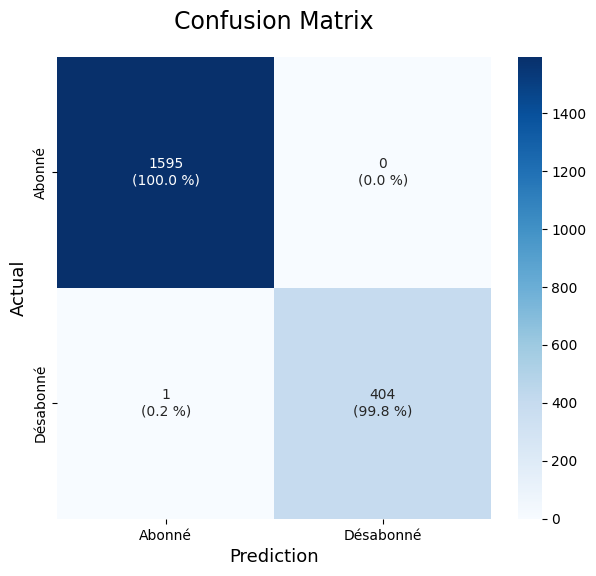

In [37]:
conf_matrix = confusion_matrix(y_test, models["LinearSVC"].predict(X_test))
# Conversion en pourcentage
conf_matrix_percent = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis] * 100

# Création des annotations combinant les valeurs et les pourcentages
annot = np.empty_like(conf_matrix).astype(str)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        annot[i, j] = f"{conf_matrix[i, j]}\n({conf_matrix_percent[i, j]:.1f} %)"

# Affichage de la matrice
plt.figure(figsize=(7, 6))
sns.heatmap(conf_matrix, annot=annot, fmt='', cmap='Blues',
            xticklabels=["Abonné", "Désabonné"],
            yticklabels=["Abonné", "Désabonné"])

plt.ylabel('Actual', fontsize=13)
plt.xlabel('Prediction', fontsize=13)
plt.title('Confusion Matrix', fontsize=17, pad=20)
plt.show()

À partir de la matrice de confusion :

* Classe "Abonné / No Exited"
    * 1595 correctement prédits
    * 0 erreur ou confusion
    * Recall = 100%

* Classe "Désabonné / Exited"
    * 404 correctement prédits
    * 1 erreur ou confusion avec la classe No Exited
    * Recall = 99.8%

* Échantillon test = 2000 clients
* Très peu d'erreurs malgré un déséquilibre de classes
* Le modèle ne se contente pas de prédire la classe majoritaire

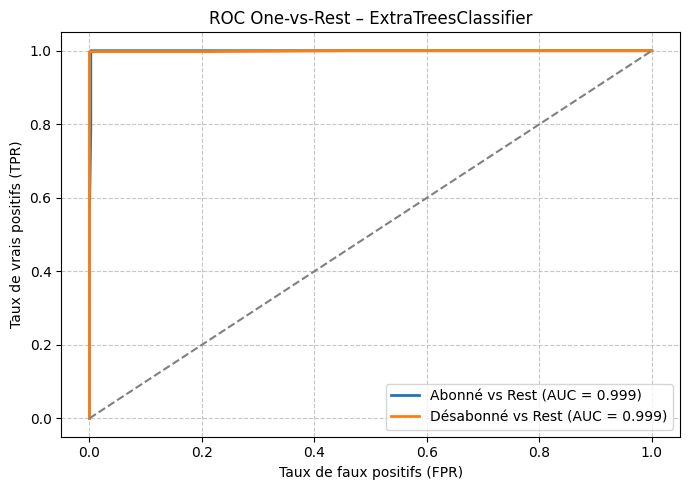

In [ ]:
def roc_matplotlib_binary_per_class(name, model, X_test, y_test, class_names=None):
    """
    Courbe ROC One-vs-Rest pour chaque classe (classification binaire)
    """
    y_score = model.predict_proba(X_test)
    classes = np.unique(y_test)

    if class_names is None:
        class_names = {0: "Classe 0", 1: "Classe 1"}

    plt.figure(figsize=(7, 5))

    for i, cls in enumerate(classes):
        y_true_bin = (y_test == cls).astype(int)
        y_prob = y_score[:, i]

        fpr, tpr, _ = roc_curve(y_true_bin, y_prob)
        roc_auc = auc(fpr, tpr)

        plt.plot(fpr, tpr,lw=2, label=f"{class_names[cls]} vs Rest (AUC = {roc_auc:.3f})")

    # Diagonale hasard
    plt.plot([0, 1], [0, 1], linestyle="--", color="gray")

    plt.title(f"ROC One-vs-Rest – {name}")
    plt.xlabel("Taux de faux positifs (FPR)")
    plt.ylabel("Taux de vrais positifs (TPR)")
    plt.legend(loc="lower right")
    plt.grid(True, linestyle="--", alpha=0.7)

    plt.tight_layout()
    plt.show()


roc_matplotlib_binary_per_class(
    name="ExtraTreesClassifier",
    model=models["ExtraTreesClassifier"],
    X_test=X_test,
    y_test=y_test,
    class_names={0: "Abonné", 1: "Désabonné"}
)


La courbe ROC (Receiver Operating Characteristic) est une représentation graphique qui montre la capacité d'un modèle à séparer les classes (ici : No Exited et Exited).

Elle trace la relation entre deux taux :

| Axe         | Signification                                             | Formule              |
| ----------- | --------------------------------------------------------- | -------------------- |
| **X (FPR)** | *Taux de faux positifs* (*False Positive Rate*)           | FPR = FP / (FP + TN) |
| **Y (TPR)** | *Taux de vrais positifs* (*True Positive Rate* ou Recall) | TPR = TP / (TP + FN) |


Cette dernière permet de visualiser la performance globale du modèle à différents seuils de classification (de 0 à 1).

La zone sous la courbe (AUC – Area Under the Curve) quantifie cette performance :

* AUC = 1.0 → modèle parfait
* AUC = 0.5 → modèle aléatoire (mauvais)

Plus l'AUC est proche de 1, meilleure est la performance.

En d'autres termes :
* La courbe ROC indique comment le modèle équilibre entre le taux de détection correcte (TPR) et le taux d'erreurs (FPR) selon différents seuils.

D'après les résultats obtenus, nous remarquons que :

> La courbe ROC du modèle ExtraTreesClassifier montre une performance quasi parfaite, avec une AUC de 0.999 pour les deux classes (No Exited et Exited). Cela signifie que le modèle est capable de discriminer correctement les classes dans 99.9 % des cas, tout en limitant fortement les faux positifs. En d'autres termes, le modèle possède une excellente capacité de classification et un très bon compromis entre sensibilité et spécificité.